# Sliding Box LSTMs for churn prediction

This notebook explores the concepts of event forecasting events or churn. This is accomplished by training a reccurent LSTM network which uses slices of time series as features and the occurence of events within these windows as labels. These sliding slices are called sliding boxes.

The notebook is structured as follows:
- exploring the problem
- generating artificial data
- defining the basic model
- training the sliding-box-LSTM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

C:\Users\Mo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Introduction

At first, let's setup some data that helps to understand the problem. Lets assume that we have a timeseries consisting of 20 timesteps and 4 binary features. This might look like this:

[[0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1]
 [1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1 1 0]
 [1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1]
 [0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1]]


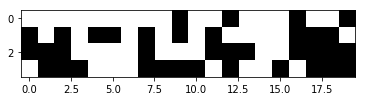

In [83]:
X = np.random.randint(0, 2, size=80).reshape(4,20)
print(X)
plt.imshow(X, cmap="binary")

Out feature vector $y$ is a binary vector that indicates at which timesteps, there is an event of out interest happening. We do not want the event to occur that often so we reduce it's probability like this:

[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]]


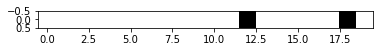

In [84]:
y = np.random.binomial(1, 0.1, size=X.shape[1]).reshape(1,-1)
print(y)
plt.imshow(y, cmap="binary")

## Goal
What we want is to predict the occurence of events (indicated by $y_i=1$) before they happen. The concept is shown below:

In [26]:
from matplotlib import patches as patches

In [94]:
def show_sliding(X, y, tau):
    
    for i in range(X.shape[1]):

        X_window = X.T[i:i+tau].T
        y_window = y.T[i:i+tau].T
        indicator = 1 if np.sum(y_window) > 0 else 0
        print("X", X_window, "y", y_window, "I", indicator)

        boxcolor = "r" if indicator else "b"

        fig, axes = plt.subplots(2, sharex=True)
        axes[0].imshow(X, cmap="Greys")
        window = patches.Rectangle((-.55 + i, -.55), tau, X.shape[0], alpha=0.4, color=boxcolor)
        axes[0].add_patch(window)

        axes[1].imshow(y, cmap="binary")
        window = patches.Rectangle((-.55 + i, -.55), tau, X.shape[0], alpha=0.4, color=boxcolor)
        axes[1].add_patch(window)

        plt.show()

X [[0 0 0]
 [1 0 1]
 [1 1 1]
 [0 1 1]] y [[0 0 0]] I 0


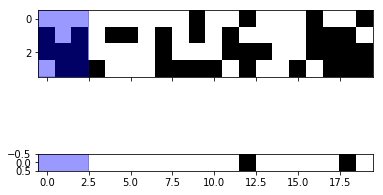

X [[0 0 0]
 [0 1 0]
 [1 1 0]
 [1 1 1]] y [[0 0 0]] I 0


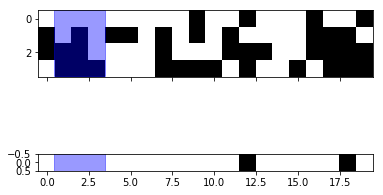

X [[0 0 0]
 [1 0 1]
 [1 0 0]
 [1 1 0]] y [[0 0 0]] I 0


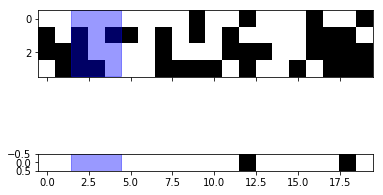

X [[0 0 0]
 [0 1 1]
 [0 0 0]
 [1 0 0]] y [[0 0 0]] I 0


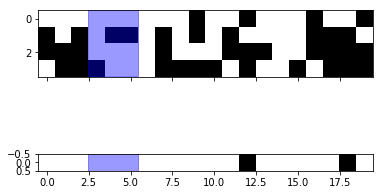

X [[0 0 0]
 [1 1 0]
 [0 0 0]
 [0 0 0]] y [[0 0 0]] I 0


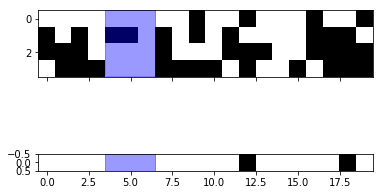

X [[0 0 0]
 [1 0 1]
 [0 0 1]
 [0 0 1]] y [[0 0 0]] I 0


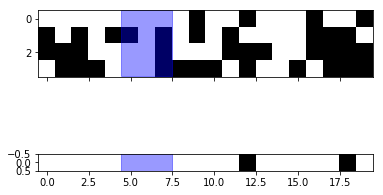

X [[0 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 1]] y [[0 0 0]] I 0


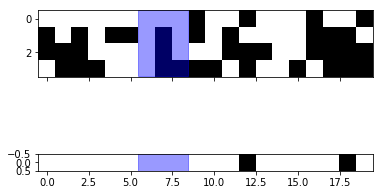

X [[0 0 1]
 [1 0 1]
 [1 0 0]
 [1 1 1]] y [[0 0 0]] I 0


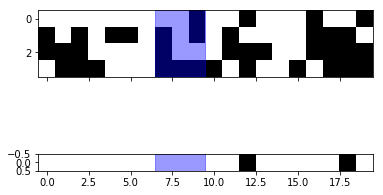

X [[0 1 0]
 [0 1 0]
 [0 0 0]
 [1 1 1]] y [[0 0 0]] I 0


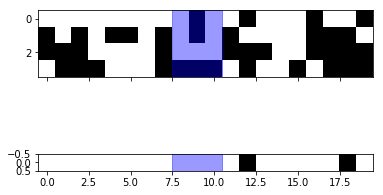

X [[1 0 0]
 [1 0 1]
 [0 0 1]
 [1 1 0]] y [[0 0 0]] I 0


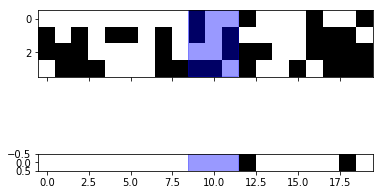

X [[0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 1]] y [[0 0 1]] I 1


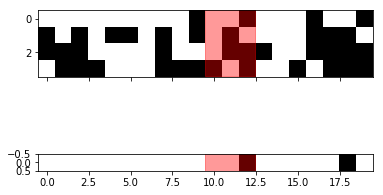

X [[0 1 0]
 [1 0 0]
 [1 1 1]
 [0 1 0]] y [[0 1 0]] I 1


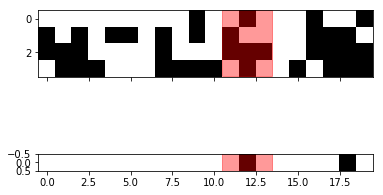

X [[1 0 0]
 [0 0 0]
 [1 1 0]
 [1 0 0]] y [[1 0 0]] I 1


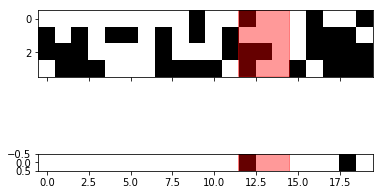

X [[0 0 0]
 [0 0 0]
 [1 0 0]
 [0 0 1]] y [[0 0 0]] I 0


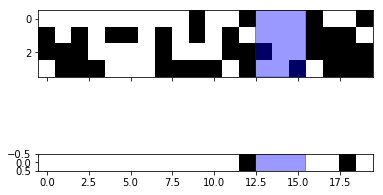

X [[0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]] y [[0 0 0]] I 0


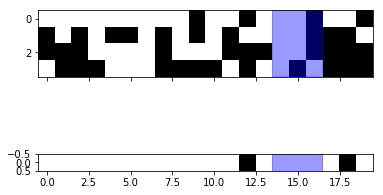

X [[0 1 0]
 [0 1 1]
 [0 1 1]
 [1 0 1]] y [[0 0 0]] I 0


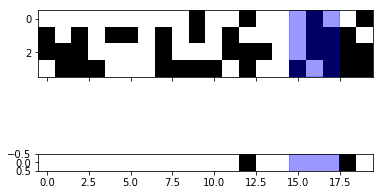

X [[1 0 0]
 [1 1 1]
 [1 1 1]
 [0 1 1]] y [[0 0 1]] I 1


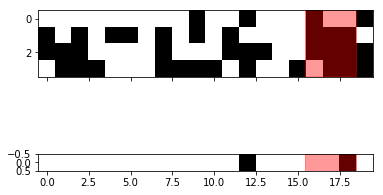

X [[0 0 1]
 [1 1 0]
 [1 1 1]
 [1 1 1]] y [[0 1 0]] I 1


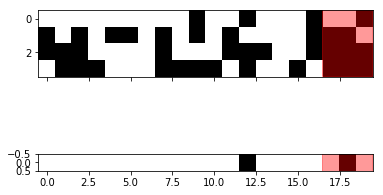

X [[0 1]
 [1 0]
 [1 1]
 [1 1]] y [[1 0]] I 1


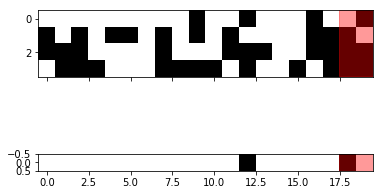

X [[1]
 [0]
 [1]
 [1]] y [[0]] I 0


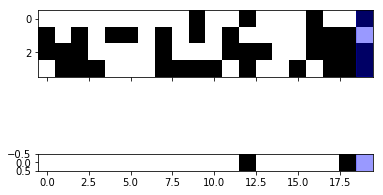

In [96]:
tau = 3     # window size
show_sliding(X, y, tau)

So our training examples at timestep $t$ comprise the slice of features from $X$ with $\tau$ timesteps ahead resulting in the slice $X_{t:t+\tau}$. The corresponding label $y^{(i)}$ for each timewindow $X_{t:t+\tau}^{(i)}$ is indicated by the occurence of an event of interest during the current time window (box becomes red).

When using this concept of binary classification, we can state so far that:
- We are able to train on sequences with arbitrary lengths
- Our time window is fixed parameter which must be chose carefully

In [86]:
# TODO: discuss choosing tau

Let's look at a model that can be used for predicting y.

# Sliding Box Model

In [87]:
# todo: describe

$$ B_t \sim Bernoulli(\theta_T) $$

$$ 
    b_t=
    \left\{
    \begin{array}{lr}
    1,& \text{If event happened in } [t, t + \tau)\\
    0,& Else
    \end{array}
    \right\}
    $$

$$ Pr(B_t=b_t)=\theta_t^{b_t} \cdot (1-\theta_t)^{1-b_t} $$

$\theta_t$ is a function of data available at time $\theta_t = g(x_{0:t})$. So we estimate the probability of an event happening in our sliding box model of width $\tau$.

$$\underset{\theta_t}{\text{maximize}}  \mathfrak{L}(\theta_t) := \theta_t^{b_t} \cdot (1-\theta_t)^{1-b_t}$$

## Build toy data

Let's build a synthetic dataset where we can run tests agains. 

In [88]:
# Makes binary features more likely towards the end of the series
def linear_increase_binomial_prob(x, scale=1):
    return np.random.binomial(1, x/(len(x)*scale), len(x))

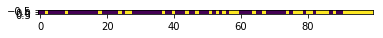

In [89]:
plt.imshow(linear_increase_binomial_prob(np.arange(100), scale=1.5).reshape(1,-1))

In [92]:
# Generate an artificial target vector
def make_y(m, p=0.08):
    return np.random.binomial(1,p,m).reshape(1,-1)

In [93]:
# Generate artificial feature vector of time series
def make_X(m, scales):
    x = np.arange(m)
    X = []
    for scale in scales:
        X.append(linear_increase_binomial_prob(x, scale))
        
    return np.array(X)

In [111]:
m = 30
scales = [10,15,1,20, 10, 5]        # vary feature distribution
    
X = make_X(m, scales)
y = make_y(m, p=0.08)

print(X)
print(y)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]]


In [113]:
# Disassembles series and it's targets to separate window slices
def convert_series_to_Xy(X, y, window):
    
    Xs = []
    Ys = []
    n = X.shape[0]
    
    for i in range(len(X.T)-window+1):

        X_window = X.T[i:i+window].T
        y_window = y.T[i:i+window].T

        indicator = 1 if np.sum(y_window) > 0 else 0
        
        Xs.append(X_window.T)
        Ys.append(indicator)
        
    return np.array(Xs), np.array(Ys).reshape(1,-1).T


In [ ]:
# input shapes are
# Samples (one sequence)
# Time Steps (one point of observation)
# Features
# --> data.shape(samples, timesteps, numfeatures) 

X [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


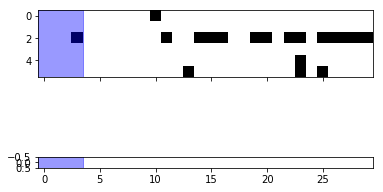

X [[0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


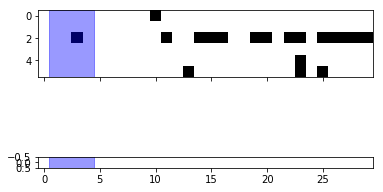

X [[0 0 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


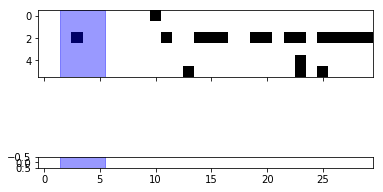

X [[0 0 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


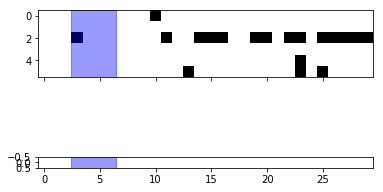

X [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


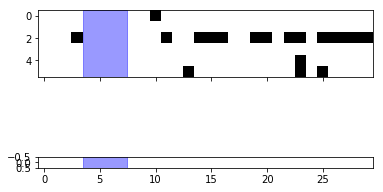

X [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


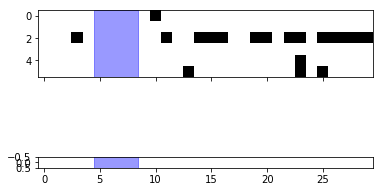

X [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


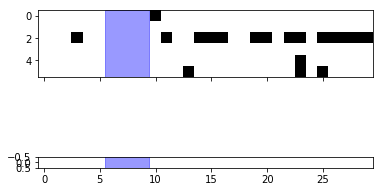

X [[0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


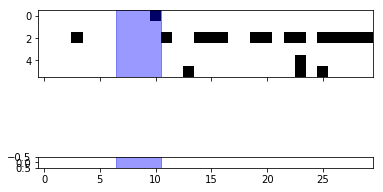

X [[0 0 1 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


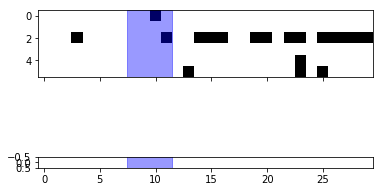

X [[0 1 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


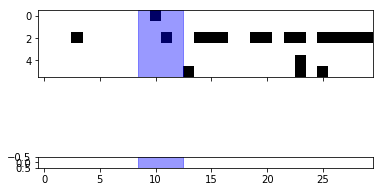

X [[1 0 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]] y [[0 0 0 0]] I 0


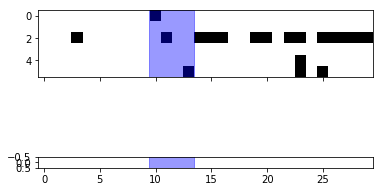

X [[0 0 0 0]
 [0 0 0 0]
 [1 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]] y [[0 0 0 0]] I 0


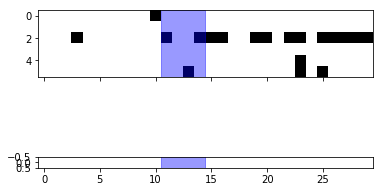

X [[0 0 0 0]
 [0 0 0 0]
 [0 0 1 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 1 0 0]] y [[0 0 0 0]] I 0


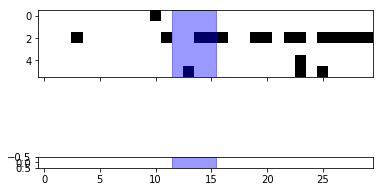

X [[0 0 0 0]
 [0 0 0 0]
 [0 1 1 1]
 [0 0 0 0]
 [0 0 0 0]
 [1 0 0 0]] y [[0 0 0 0]] I 0


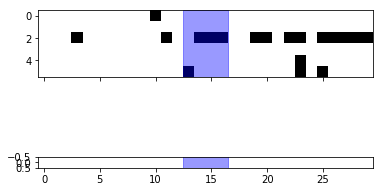

X [[0 0 0 0]
 [0 0 0 0]
 [1 1 1 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


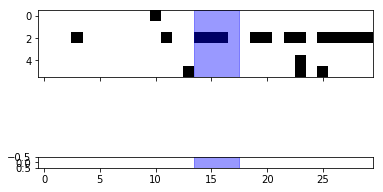

X [[0 0 0 0]
 [0 0 0 0]
 [1 1 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


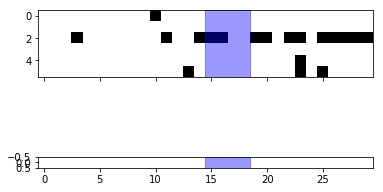

X [[0 0 0 0]
 [0 0 0 0]
 [1 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


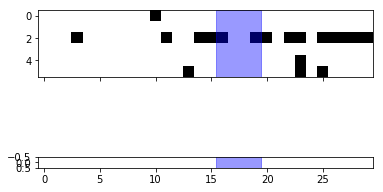

X [[0 0 0 0]
 [0 0 0 0]
 [0 0 1 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


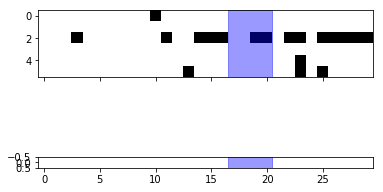

X [[0 0 0 0]
 [0 0 0 0]
 [0 1 1 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


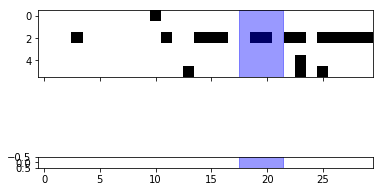

X [[0 0 0 0]
 [0 0 0 0]
 [1 1 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


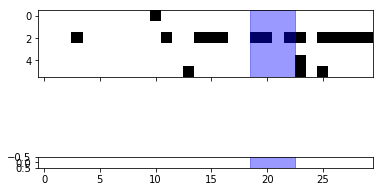

X [[0 0 0 0]
 [0 0 0 0]
 [1 0 1 1]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 1]] y [[0 0 0 0]] I 0


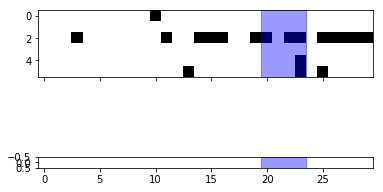

X [[0 0 0 0]
 [0 0 0 0]
 [0 1 1 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 1 0]] y [[0 0 0 0]] I 0


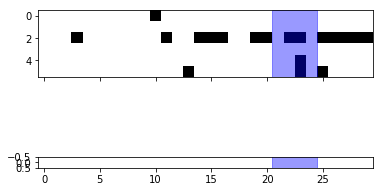

X [[0 0 0 0]
 [0 0 0 0]
 [1 1 0 1]
 [0 0 0 0]
 [0 1 0 0]
 [0 1 0 1]] y [[0 0 0 0]] I 0


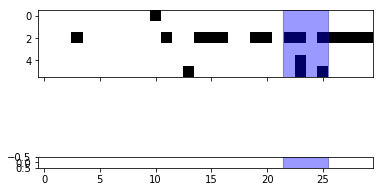

X [[0 0 0 0]
 [0 0 0 0]
 [1 0 1 1]
 [0 0 0 0]
 [1 0 0 0]
 [1 0 1 0]] y [[0 0 0 0]] I 0


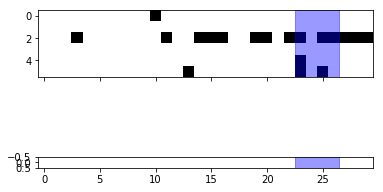

X [[0 0 0 0]
 [0 0 0 0]
 [0 1 1 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 1 0 0]] y [[0 0 0 0]] I 0


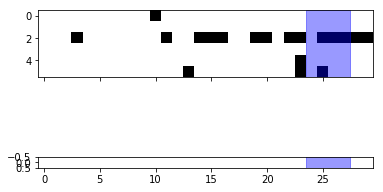

X [[0 0 0 0]
 [0 0 0 0]
 [1 1 1 1]
 [0 0 0 0]
 [0 0 0 0]
 [1 0 0 0]] y [[0 0 0 0]] I 0


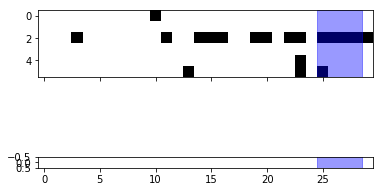

X [[0 0 0 0]
 [0 0 0 0]
 [1 1 1 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]] y [[0 0 0 0]] I 0


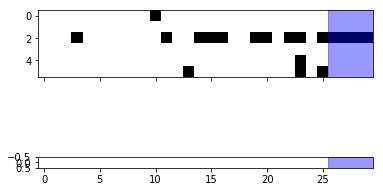

X [[0 0 0]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]] y [[0 0 0]] I 0


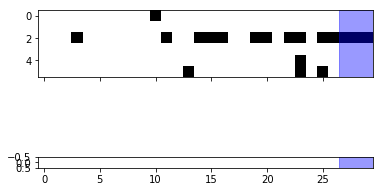

X [[0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]] y [[0 0]] I 0


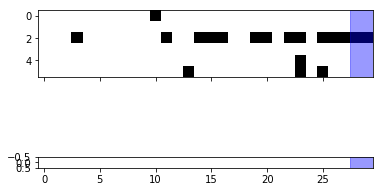

X [[0]
 [0]
 [1]
 [0]
 [0]
 [0]] y [[0]] I 0


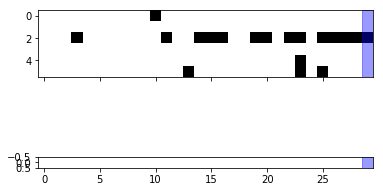

In [105]:
show_sliding(X, y, 4)

In [119]:
print(X.shape)
print(y.shape)

(6, 30)
(1, 30)


In [114]:
tau = 4
n   = X.shape[0]

Xs, Ys = convert_series_to_Xy(X, y, tau)
print(Xs.shape)
print(Ys.shape)

(27, 4, 6)
(27, 1)


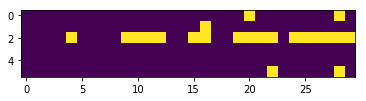

In [121]:
plt.imshow(X)

In [123]:
Xs[1].T      # second time box

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [124]:
def make_model(tau, n):
    
    model = Sequential()
    model.add(LSTM(32, input_shape=(tau, n)))
    model.add(Dense(1, activation="sigmoid"))
    
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])    # Bernoulli Log-Likelihood
    
    return model

In [125]:
model = make_model(tau, n)

In [128]:
result = model.fit(Xs, Ys, epochs=1000, batch_size=32)

Epoch 1/1000
27/27 [==============================] - 0s 222us/sample - loss: 0.0562 - accuracy: 0.9630
Epoch 2/1000
27/27 [==============================] - 0s 166us/sample - loss: 0.0562 - accuracy: 0.9630
Epoch 3/1000
27/27 [==============================] - 0s 204us/sample - loss: 0.0562 - accuracy: 0.9630
Epoch 4/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0562 - accuracy: 0.9630
Epoch 5/1000
27/27 [==============================] - 0s 185us/sample - loss: 0.0562 - accuracy: 0.9630
Epoch 6/1000
27/27 [==============================] - 0s 130us/sample - loss: 0.0562 - accuracy: 0.9630
Epoch 7/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0562 - accuracy: 0.9630
Epoch 8/1000
27/27 [==============================] - 0s 185us/sample - loss: 0.0561 - accuracy: 0.9630
Epoch 9/1000
27/27 [==============================] - 0s 130us/sample - loss: 0.0561 - accuracy: 0.9630
Epoch 10/1000
27/27 [==============================] - 0s 148us/

Epoch 80/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0553 - accuracy: 0.9630
Epoch 81/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0552 - accuracy: 0.9630
Epoch 82/1000
27/27 [==============================] - 0s 222us/sample - loss: 0.0552 - accuracy: 0.9630
Epoch 83/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0552 - accuracy: 0.9630
Epoch 84/1000
27/27 [==============================] - 0s 333us/sample - loss: 0.0552 - accuracy: 0.9630
Epoch 85/1000
27/27 [==============================] - 0s 203us/sample - loss: 0.0552 - accuracy: 0.9630
Epoch 86/1000
27/27 [==============================] - 0s 241us/sample - loss: 0.0552 - accuracy: 0.9630
Epoch 87/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0552 - accuracy: 0.9630
Epoch 88/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0552 - accuracy: 0.9630
Epoch 89/1000
27/27 [==============================] - 

Epoch 158/1000
27/27 [==============================] - 0s 204us/sample - loss: 0.0546 - accuracy: 0.9630
Epoch 159/1000
27/27 [==============================] - 0s 278us/sample - loss: 0.0547 - accuracy: 0.9630
Epoch 160/1000
27/27 [==============================] - 0s 241us/sample - loss: 0.0547 - accuracy: 0.9630
Epoch 161/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0549 - accuracy: 0.9630
Epoch 162/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0550 - accuracy: 0.9630
Epoch 163/1000
27/27 [==============================] - 0s 222us/sample - loss: 0.0552 - accuracy: 0.9630
Epoch 164/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0552 - accuracy: 0.9630
Epoch 165/1000
27/27 [==============================] - 0s 204us/sample - loss: 0.0549 - accuracy: 0.9630
Epoch 166/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0546 - accuracy: 0.9630
Epoch 167/1000
27/27 [========================

Epoch 236/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0540 - accuracy: 0.9630
Epoch 237/1000
27/27 [==============================] - 0s 222us/sample - loss: 0.0540 - accuracy: 0.9630
Epoch 238/1000
27/27 [==============================] - 0s 185us/sample - loss: 0.0540 - accuracy: 0.9630
Epoch 239/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0540 - accuracy: 0.9630
Epoch 240/1000
27/27 [==============================] - 0s 222us/sample - loss: 0.0540 - accuracy: 0.9630
Epoch 241/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0540 - accuracy: 0.9630
Epoch 242/1000
27/27 [==============================] - 0s 222us/sample - loss: 0.0540 - accuracy: 0.9630
Epoch 243/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0540 - accuracy: 0.9630
Epoch 244/1000
27/27 [==============================] - 0s 204us/sample - loss: 0.0540 - accuracy: 0.9630
Epoch 245/1000
27/27 [========================

Epoch 314/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0537 - accuracy: 0.9630
Epoch 315/1000
27/27 [==============================] - 0s 204us/sample - loss: 0.0540 - accuracy: 0.9630
Epoch 316/1000
27/27 [==============================] - 0s 130us/sample - loss: 0.0542 - accuracy: 0.9630
Epoch 317/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0540 - accuracy: 0.9630
Epoch 318/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0536 - accuracy: 0.9630
Epoch 319/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0537 - accuracy: 0.9630
Epoch 320/1000
27/27 [==============================] - 0s 278us/sample - loss: 0.0540 - accuracy: 0.9630
Epoch 321/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0539 - accuracy: 0.9630
Epoch 322/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0536 - accuracy: 0.9630
Epoch 323/1000
27/27 [========================

Epoch 392/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0533 - accuracy: 0.9630
Epoch 393/1000
27/27 [==============================] - 0s 204us/sample - loss: 0.0533 - accuracy: 0.9630
Epoch 394/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0533 - accuracy: 0.9630
Epoch 395/1000
27/27 [==============================] - 0s 278us/sample - loss: 0.0533 - accuracy: 0.9630
Epoch 396/1000
27/27 [==============================] - 0s 185us/sample - loss: 0.0533 - accuracy: 0.9630
Epoch 397/1000
27/27 [==============================] - 0s 222us/sample - loss: 0.0533 - accuracy: 0.9630
Epoch 398/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0533 - accuracy: 0.9630
Epoch 399/1000
27/27 [==============================] - 0s 130us/sample - loss: 0.0533 - accuracy: 0.9630
Epoch 400/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0533 - accuracy: 0.9630
Epoch 401/1000
27/27 [========================

Epoch 470/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0531 - accuracy: 0.9630
Epoch 471/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0531 - accuracy: 0.9630
Epoch 472/1000
27/27 [==============================] - 0s 296us/sample - loss: 0.0531 - accuracy: 0.9630
Epoch 473/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0531 - accuracy: 0.9630
Epoch 474/1000
27/27 [==============================] - 0s 333us/sample - loss: 0.0531 - accuracy: 0.9630
Epoch 475/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0531 - accuracy: 0.9630
Epoch 476/1000
27/27 [==============================] - 0s 241us/sample - loss: 0.0531 - accuracy: 0.9630
Epoch 477/1000
27/27 [==============================] - 0s 225us/sample - loss: 0.0531 - accuracy: 0.9630
Epoch 478/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0531 - accuracy: 0.9630
Epoch 479/1000
27/27 [========================

Epoch 548/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0529 - accuracy: 0.9630
Epoch 549/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0529 - accuracy: 0.9630
Epoch 550/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0529 - accuracy: 0.9630
Epoch 551/1000
27/27 [==============================] - 0s 278us/sample - loss: 0.0529 - accuracy: 0.9630
Epoch 552/1000
27/27 [==============================] - 0s 185us/sample - loss: 0.0529 - accuracy: 0.9630
Epoch 553/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0529 - accuracy: 0.9630
Epoch 554/1000
27/27 [==============================] - 0s 222us/sample - loss: 0.0529 - accuracy: 0.9630
Epoch 555/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0529 - accuracy: 0.9630
Epoch 556/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0529 - accuracy: 0.9630
Epoch 557/1000
27/27 [========================

Epoch 626/1000
27/27 [==============================] - 0s 315us/sample - loss: 0.0527 - accuracy: 0.9630
Epoch 627/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0527 - accuracy: 0.9630
Epoch 628/1000
27/27 [==============================] - 0s 278us/sample - loss: 0.0527 - accuracy: 0.9630
Epoch 629/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0527 - accuracy: 0.9630
Epoch 630/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0527 - accuracy: 0.9630
Epoch 631/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0527 - accuracy: 0.9630
Epoch 632/1000
27/27 [==============================] - 0s 166us/sample - loss: 0.0527 - accuracy: 0.9630
Epoch 633/1000
27/27 [==============================] - 0s 315us/sample - loss: 0.0527 - accuracy: 0.9630
Epoch 634/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0527 - accuracy: 0.9630
Epoch 635/1000
27/27 [========================

Epoch 704/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0526 - accuracy: 0.9630
Epoch 705/1000
27/27 [==============================] - 0s 204us/sample - loss: 0.0526 - accuracy: 0.9630
Epoch 706/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0526 - accuracy: 0.9630
Epoch 707/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0526 - accuracy: 0.9630
Epoch 708/1000
27/27 [==============================] - 0s 259us/sample - loss: 0.0526 - accuracy: 0.9630
Epoch 709/1000
27/27 [==============================] - 0s 333us/sample - loss: 0.0525 - accuracy: 0.9630
Epoch 710/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0525 - accuracy: 0.9630
Epoch 711/1000
27/27 [==============================] - 0s 185us/sample - loss: 0.0525 - accuracy: 0.9630
Epoch 712/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0525 - accuracy: 0.9630
Epoch 713/1000
27/27 [========================

Epoch 782/1000
27/27 [==============================] - 0s 130us/sample - loss: 0.0524 - accuracy: 0.9630
Epoch 783/1000
27/27 [==============================] - 0s 370us/sample - loss: 0.0524 - accuracy: 0.9630
Epoch 784/1000
27/27 [==============================] - 0s 204us/sample - loss: 0.0524 - accuracy: 0.9630
Epoch 785/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0524 - accuracy: 0.9630
Epoch 786/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0524 - accuracy: 0.9630
Epoch 787/1000
27/27 [==============================] - 0s 204us/sample - loss: 0.0524 - accuracy: 0.9630
Epoch 788/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0524 - accuracy: 0.9630
Epoch 789/1000
27/27 [==============================] - 0s 259us/sample - loss: 0.0524 - accuracy: 0.9630
Epoch 790/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0524 - accuracy: 0.9630
Epoch 791/1000
27/27 [========================

Epoch 860/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0523 - accuracy: 0.9630
Epoch 861/1000
27/27 [==============================] - 0s 278us/sample - loss: 0.0523 - accuracy: 0.9630
Epoch 862/1000
27/27 [==============================] - 0s 185us/sample - loss: 0.0523 - accuracy: 0.9630
Epoch 863/1000
27/27 [==============================] - 0s 222us/sample - loss: 0.0523 - accuracy: 0.9630
Epoch 864/1000
27/27 [==============================] - 0s 204us/sample - loss: 0.0523 - accuracy: 0.9630
Epoch 865/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0523 - accuracy: 0.9630
Epoch 866/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0523 - accuracy: 0.9630
Epoch 867/1000
27/27 [==============================] - 0s 222us/sample - loss: 0.0523 - accuracy: 0.9630
Epoch 868/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0523 - accuracy: 0.9630
Epoch 869/1000
27/27 [========================

Epoch 938/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0522 - accuracy: 0.9630
Epoch 939/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0522 - accuracy: 0.9630
Epoch 940/1000
27/27 [==============================] - 0s 222us/sample - loss: 0.0522 - accuracy: 0.9630
Epoch 941/1000
27/27 [==============================] - 0s 204us/sample - loss: 0.0522 - accuracy: 0.9630
Epoch 942/1000
27/27 [==============================] - 0s 241us/sample - loss: 0.0522 - accuracy: 0.9630
Epoch 943/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0522 - accuracy: 0.9630
Epoch 944/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0522 - accuracy: 0.9630
Epoch 945/1000
27/27 [==============================] - 0s 167us/sample - loss: 0.0522 - accuracy: 0.9630
Epoch 946/1000
27/27 [==============================] - 0s 148us/sample - loss: 0.0522 - accuracy: 0.9630
Epoch 947/1000
27/27 [========================

In [131]:
predictions = model.predict(Xs)

## Show Predictions

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] [0] [3.0130148e-05]


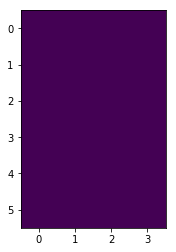

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]] [0] [0.00021029]


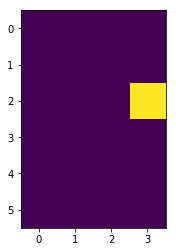

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]] [0] [0.00010169]


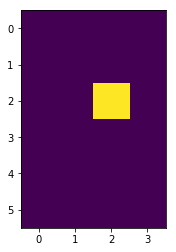

[[0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] [0] [4.4703484e-07]


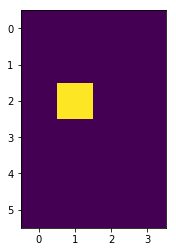

[[0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] [0] [1.1920929e-07]


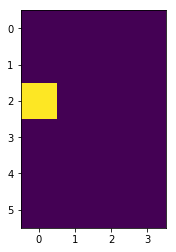

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] [0] [3.0130148e-05]


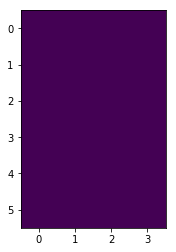

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]] [0] [0.00021029]


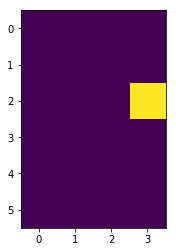

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]] [0] [0.00245202]


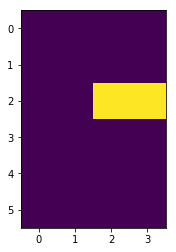

[[0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]] [0] [0.00020841]


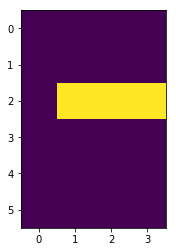

[[0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]] [0] [0.4923697]


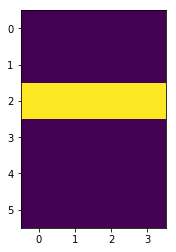

[[0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]] [0] [0.01093975]


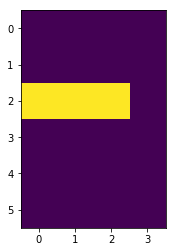

[[0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] [0] [3.0696392e-06]


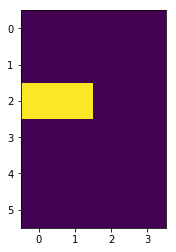

[[0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]] [0] [4.7683716e-07]


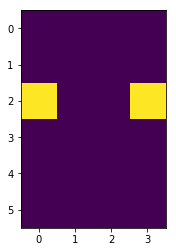

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 1 0 0 0]] [1] [0.99500227]


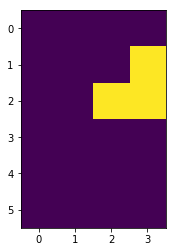

[[0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 1 0 0 0]
 [0 0 0 0 0 0]] [1] [0.9999762]


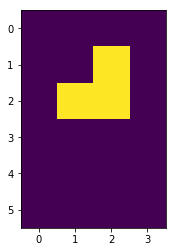

[[0 0 1 0 0 0]
 [0 1 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] [1] [0.99993396]


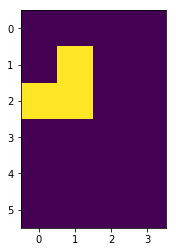

[[0 1 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]] [1] [0.9998306]


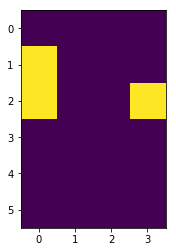

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [1 0 1 0 0 0]] [0] [0.00095284]


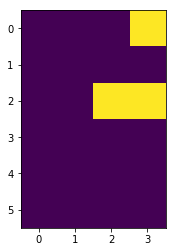

[[0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [1 0 1 0 0 0]
 [0 0 1 0 0 0]] [0] [1.6510487e-05]


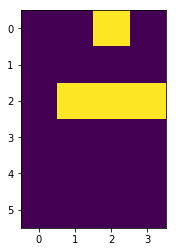

[[0 0 1 0 0 0]
 [1 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 1]] [0] [6.771088e-05]


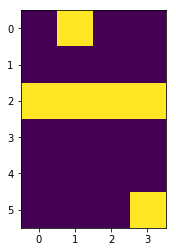

[[1 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 1]
 [0 0 0 0 0 0]] [0] [2.9802322e-08]


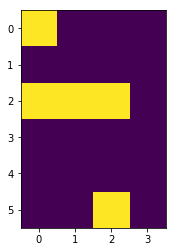

[[0 0 1 0 0 0]
 [0 0 1 0 0 1]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]] [0] [0.00013971]


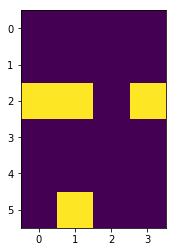

[[0 0 1 0 0 1]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]] [0] [1.1920929e-07]


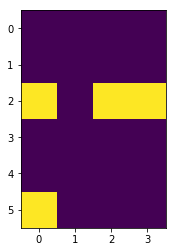

[[0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]] [0] [0.00020841]


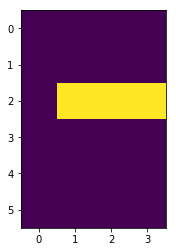

[[0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]] [1] [0.49237087]


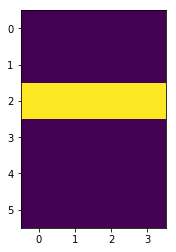

[[0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [1 0 1 0 0 1]] [1] [0.9986828]


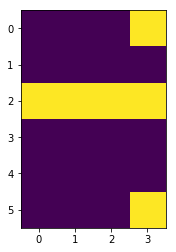

[[0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [1 0 1 0 0 1]
 [0 0 1 0 0 0]] [1] [0.9997726]


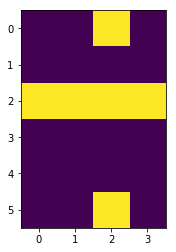

In [130]:
for i, j, pred in zip(Xs, Ys, predictions):
    
    print(i, j, pred)
    plt.imshow(i.T)
    plt.show()